# MINUIT-like errors with alternative pyhf backends

This notebooks explains how one can compute MINUIT-like parameter errors compares how those errors compare
to the "standard error" given by the square root of the diagonal elements of the covariance matrix


In [1]:
import jax
import jax.numpy as jnp
import iminuit
from jax.config import config
import pyhf
import scipy.optimize

config.update('jax_enable_x64', True)
pyhf.set_backend('jax')


def toinf_single(x, bounds):
    lo, hi = bounds
    return jax.numpy.arcsin(2 * (x - lo) / (hi - lo) - 1)


def tobnd_single(x, bounds):
    lo, hi = bounds
    return lo + 0.5 * (hi - lo) * (jax.numpy.sin(x) + 1)


def _calc_minuit_errors(infmin, minim, inf_inv_hess, barray):
    '''The core routine for MINUIT-like errors from an internal Hessian'''
    # https://root.cern.ch/doc/master/classROOT_1_1Minuit2_1_1MnUserTransformation.html#ad900f367f4d2c5df13f899dd55bdf212
    errs = jnp.sqrt(jnp.diag(inf_inv_hess))
    infmin = jax.vmap(toinf_single)(minim, barray)
    up = jax.vmap(tobnd_single)(infmin + errs, barray) - minim
    dn = jax.vmap(tobnd_single)(infmin - errs, barray) - minim
    up = jnp.where(
        errs > 1, barray[:, 1] - barray[:, 0], up
    )  # it's unclear to me why this is done
    fn = (jnp.abs(up) + jnp.abs(dn)) * 0.5
    return fn


def calc_minuit_errors(objective, minim, barray):
    '''This computes MINUIT-like errors'''

    def internal_obj(x):
        ext = jax.vmap(tobnd_single)(x, barray)
        return objective(ext)

    infmin = jax.vmap(toinf_single)(minim, barray)
    internal_hessian = jax.hessian(internal_obj)(infmin)
    inf_inv_hess = jax.numpy.linalg.inv(internal_hessian)

    minuit_errors = _calc_minuit_errors(infmin, minim, inf_inv_hess, barray)
    return minuit_errors


def run_via_pyhf_scipy(objective, data_pdf, init, barray):
    '''This version runs the standard pyhf interface but computes minuit-like errors'''
    minim = pyhf.infer.mle.fit(*data_pdf)
    minuit_errors = calc_minuit_errors(objective, minim, barray)
    return minuit_errors


def run_raw_scipy(objective, init, barray):
    '''This version runs the raw scipy optimization and computes minuit-like errors'''

    minim = scipy.optimize.minimize(objective, jnp.array(init), bounds=barray).x

    minuit_errors = calc_minuit_errors(objective, minim, barray)

    external_hessian = jax.hessian(objective)(minim)
    inv_hess = jax.numpy.linalg.inv(external_hessian)
    sqrt_inv_hess_err = jnp.sqrt(jnp.diag(inv_hess))
    return minuit_errors, sqrt_inv_hess_err


def run_pyhf_minuit(data_pdf, grad=False):
    '''This version runs the raw scipy optimization and computes minuit-like errors'''
    result = pyhf.infer.mle.fit(*data_pdf, return_uncertainties=True, do_grad=grad)
    return result


def raw_minuit(objective, init, barray):
    '''This version runs just raw minuit without pyhf'''
    m = iminuit.Minuit(
        objective,
        use_array_call=True,
        forced_parameters=['p1', 'p2'],
        errordef=0.5,
        p1=init[0],
        p2=init[1],
        error_p1=0.01,
        error_p2=0.01,
        limit_p1=barray[0],
        limit_p2=barray[1],
    )
    m.strategy = 0
    m.migrad()
    m.hesse()
    return m.np_errors()


def run_error_analysis(pdf, obs_count):
    data = jnp.array([obs_count] + pdf.config.auxdata)

    def func(x):
        return -2.0 * pdf.logpdf(x, data)[0]

    bounds = jnp.array(pdf.config.suggested_bounds())
    init = jnp.array(pdf.config.suggested_init())

    pyhf.set_backend('jax', 'scipy')

    min_errors = raw_minuit(func, init, bounds)
    pyhf_scipy_minuit_errors = run_via_pyhf_scipy(func, (data, pdf), init, bounds)
    scipy_minuit_errors, sqrt_inv_hess_err = run_raw_scipy(func, init, bounds)

    pyhf.set_backend('jax', pyhf.optimize.minuit_optimizer(errordef=0.5))
    result_nograd = run_pyhf_minuit((data, pdf), grad=False)
    result_grad = run_pyhf_minuit((data, pdf), grad=True)
    return {
        'sqrt inv hessian': sqrt_inv_hess_err,
        'raw scipy + AD minuit-like': scipy_minuit_errors,
        'pyhf scipy + AD minuit-like': pyhf_scipy_minuit_errors,
        'raw minuit': min_errors,
        'pyhf minuit iface bo AD ': result_nograd[:, 1],
        'pyhf minuit iface AD': result_grad[:, 1],
    }


def run_scan(scan):
    pdf = pyhf.simplemodels.hepdata_like([2.0], [50.0], [5.0])
    data = {}
    for o in scan:
        d = run_error_analysis(pdf, o)
        for k, v in d.items():
            data.setdefault(k, []).append(v)
    for k, v in d.items():
        data[k] = jnp.array(data[k])
    return data

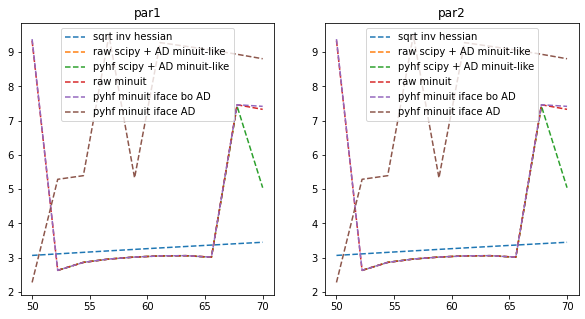

In [2]:
import matplotlib.pyplot as plt

scan = jnp.linspace(50, 70, 10)
data = run_scan(scan)


f, axarr = plt.subplots(1, 2)
f.set_size_inches(10, 5)
for k, v in data.items():
    axarr[0].plot(scan, v[:, 0], label=k, linestyle='dashed')
    axarr[0].set_title('par1')
    axarr[0].legend()
    axarr[1].plot(scan, v[:, 0], label=k, linestyle='dashed')
    axarr[1].set_title('par2')
    axarr[1].legend()